# LD segmentation using the stardist algorithm 


This code is based on the stardist algorithm described in following publications


    Uwe Schmidt, Martin Weigert, Coleman Broaddus, and Gene Myers.
    Cell Detection with Star-convex Polygons.
    International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI), Granada, Spain, September 2018.

    Martin Weigert, Uwe Schmidt, Robert Haase, Ko Sugawara, and Gene Myers.
    Star-convex Polyhedra for 3D Object Detection and Segmentation in Microscopy.
    The IEEE Winter Conference on Applications of Computer Vision (WACV), Snowmass Village, Colorado, March 2020

The code adapted here is from their github repository:

https://github.com/mpicbg-csbd/stardist

Adaptions to the source code are marked in seperate cells

In [42]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import pathlib

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

import time

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [43]:
#Adaption: List of the existing models 
modelList= sorted(glob('models\\**'))

for item in modelList:
    print (Path(item).stem)

LD-CARS-grid-1-2
LD-CARS-grid-2-1-mouse


In [44]:
#Adaption: Please select a model from the list here!

selectedModel= "LD-CARS-grid-2-1-mouse"

print("Model selected=", selectedModel)

Model selected= LD-CARS-grid-2-1-mouse


In [45]:
X = sorted(glob('**/*1.tif'))

#<Adaption>
imageFilePaths=X
#</Adaption>

X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [46]:
#Adaption: Getting the folders to save the ROIs in them later

names=[]
folder=[]

for item in imageFilePaths:
    _parent=Path(item).parent
    _name=Path(item).name
    
    folder.append(_parent)
    names.append(_name)
    
print(folder)

[WindowsPath('chloroquime-OA-50mum_chloroquine-OA-50mum-merged'), WindowsPath('chloroquime-OA-50mum_chlroquine-BSA-50mum-merged'), WindowsPath('chloroquime-OA-50mum_control-BSA-50mum-merged'), WindowsPath('chloroquime-OA-50mum_control-OA-50mum-merged'), WindowsPath('mousepilot-100mum-11092020_Chloroquine-BSA-100mum-merged'), WindowsPath('mousepilot-100mum-11092020_Chloroquine-OA-100mum-merged'), WindowsPath('mousepilot-100mum-11092020_control BSA 100mum merged'), WindowsPath('mousepilot-100mum-11092020_control-OA-100mum merged'), WindowsPath('mousepilot-10mum-11092020_chloroquine-BSA-10mum-merged'), WindowsPath('mousepilot-10mum-11092020_chloroquine-OA-10mum-merged'), WindowsPath('mousepilot-10mum-11092020_control-BSA-10mum-merged'), WindowsPath('mousepilot-10mum-11092020_control-OA-10mum-merged'), WindowsPath('mousepilot-25mum-11092020_chloroquine-BSA-25mum-merged'), WindowsPath('mousepilot-25mum-11092020_chloroquine-OA-25mum-merged'), WindowsPath('mousepilot-25mum-11092020_control-BS

The model is loaded here:

In [47]:
model = StarDist2D(None,  name=selectedModel, basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.497649, nms_thresh=0.3.


## Trial run for one image

If you already know that there are no major artifacts, obmit this section. This is just a quick check if the image is loaded and segmented properly. The image, in this case number 3 in the list is saved as example image, the labels as example labels and the rois as example rois.

In [48]:
img = normalize(X[2], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

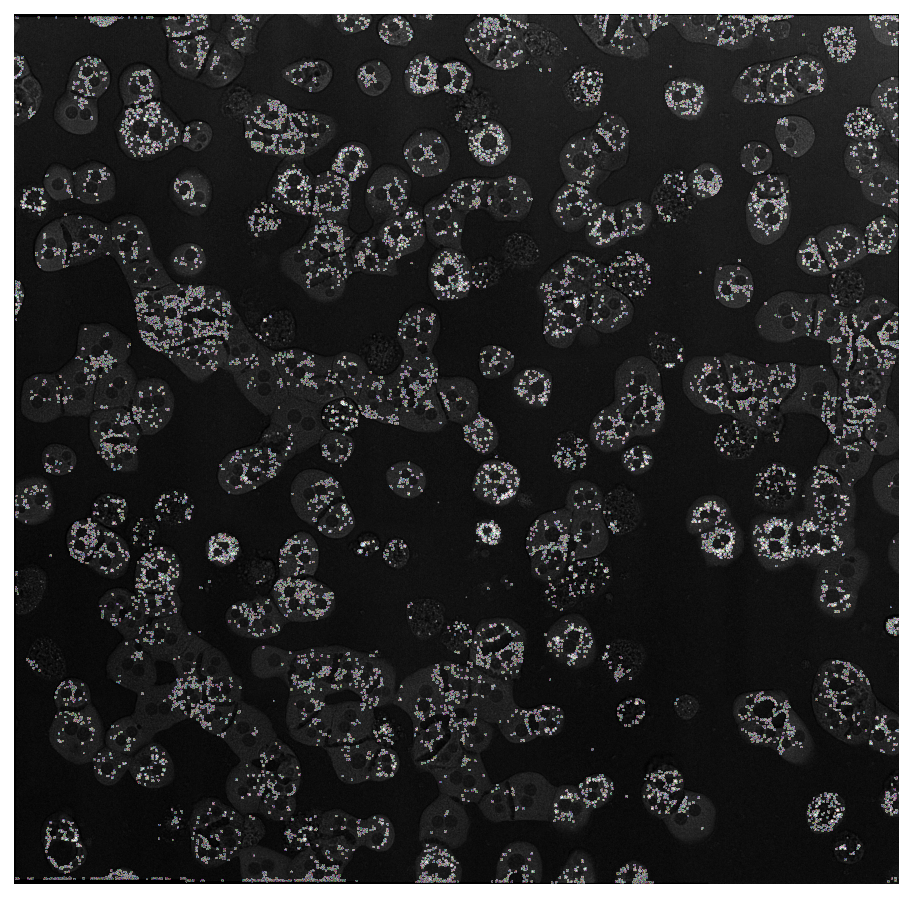

In [49]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

In [50]:
save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
export_imagej_rois('example_rois.zip', details['coord'])

## Run through all the folders

The following code is adapted from the example image code above. It saves the images, labels and rois in the folder of the original image. Images and labels are commented out, since they are not necessary to progress.

In [51]:
i=0
for item in X:
    t0 = time.time()
    print(names[i])
    
    img = normalize(item, 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    
    savename=os.path.join(folder[i],names[i])
    
    #save_tiff_imagej_compatible(savename+'_image.tif', img, axes='YX')
    #save_tiff_imagej_compatible(savename+'_labels.tif', labels, axes='YX')
    export_imagej_rois(savename[:4]+'_rois.zip', details['coord'])    
    
    t1 = time.time()
    total = t1-t0
    print(total)
    
    i+=1
    
print ("done")

chloroquime-OA-50mum_chloroquine-OA-50mum-merged_ch01.tif
7.738826751708984
chloroquime-OA-50mum_chlroquine-BSA-50mum-merged_ch01.tif
8.533735036849976
chloroquime-OA-50mum_control-BSA-50mum-merged_ch01.tif
13.68562388420105
chloroquime-OA-50mum_control-OA-50mum-merged_ch01.tif
13.78336787223816
mousepilot-100mum-11092020_Chloroquine-BSA-100mum-merged_ch01.tif
8.221131801605225
mousepilot-100mum-11092020_Chloroquine-OA-100mum-merged_ch01.tif
8.626954078674316
mousepilot-100mum-11092020_control BSA 100mum merged_ch01.tif
11.21482515335083
mousepilot-100mum-11092020_control-OA-100mum merged_ch01.tif
16.955527782440186
mousepilot-10mum-11092020_chloroquine-BSA-10mum-merged_ch01.tif
13.688916206359863
mousepilot-10mum-11092020_chloroquine-OA-10mum-merged_ch01.tif
16.20489525794983
mousepilot-10mum-11092020_control-BSA-10mum-merged_ch01.tif
7.487077713012695
mousepilot-10mum-11092020_control-OA-10mum-merged_ch01.tif
17.874632596969604
mousepilot-25mum-11092020_chloroquine-BSA-25mum-merged_c